# Linear Interpolation for Sensor Data

This notebook performs linear interpolation for missing values in sensor data.

## Setup

Install required dependencies:
```bash
pip install -r requirements.txt
```

Required packages:
- `pandas`: Data manipulation and Excel file handling
- `openpyxl`: Excel file reading/writing support


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Read the Excel file
file_path = 'data/raw/panel_temperature_and_light_raw_dataset_MK_2025_december_3.xlsx'
df = pd.read_excel(file_path)

# Filter for sensor_id 1 and select datetime, upper_temp_C, upper_humidity, and upper_irradiance
columns_to_process = ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance(μW/cm²)']
sensor_1_data = df[df['sensor_id'] == 1][columns_to_process].copy()

# Convert datetime to datetime type
sensor_1_data['datetime'] = pd.to_datetime(sensor_1_data['datetime'])

# Sort by datetime
sensor_1_data = sensor_1_data.sort_values('datetime').reset_index(drop=True)

print("Original data:")
print(f"Data shape: {sensor_1_data.shape}")
print(f"Time range: {sensor_1_data['datetime'].min()} to {sensor_1_data['datetime'].max()}")
print(f"\nFirst few rows (original timestamps):")
print(sensor_1_data.head(10))

# Step 1: Remove duplicate datetimes (keep first occurrence)
duplicates_before = len(sensor_1_data)
sensor_1_data = sensor_1_data.drop_duplicates(subset=['datetime'], keep='first')
duplicates_removed = duplicates_before - len(sensor_1_data)
if duplicates_removed > 0:
    print(f"\nRemoved {duplicates_removed} duplicate datetime entries")

# Step 2: Set datetime as index
sensor_1_indexed = sensor_1_data.set_index('datetime')

# Step 3: Create regular 10-minute intervals starting from 2025-08-12 17:00:00
start_time = pd.Timestamp('2025-08-12 17:00:00')
end_time = sensor_1_indexed.index.max()

# Align start_time: if data starts before 17:00:00, use 17:00:00; otherwise align to next 10-min interval
data_start = sensor_1_indexed.index.min()
if data_start < start_time:
    resample_start = start_time
else:
    # Find the next 10-minute interval from start_time that is >= data_start
    time_since_start = (data_start - start_time).total_seconds() / 60
    intervals_since_start = int((time_since_start // 10) + (1 if time_since_start % 10 > 0 else 0))
    resample_start = start_time + pd.Timedelta(minutes=10 * intervals_since_start)

# Create date range with 10-minute frequency (target grid)
resample_range = pd.date_range(
    start=resample_start,
    end=end_time,
    freq='10min'  # 10 minutes
)

print(f"\nCreating 10-minute grid:")
print(f"  Start time: {resample_start}")
print(f"  End time: {end_time}")
print(f"  Number of grid points: {len(resample_range)}")
print(f"  First few grid points: {resample_range[:5].tolist()}")

# Step 4: Union the original timestamps (anchors) and the 10-minute grid (targets)
original_index = sensor_1_indexed.index
combined_index = original_index.union(resample_range).sort_values()

print(f"\nCombined index (original + grid):")
print(f"  Original timestamps: {len(original_index)}")
print(f"  Grid timestamps: {len(resample_range)}")
print(f"  Combined (union): {len(combined_index)}")

# Step 5: Reindex to the combined index (includes both original and grid timestamps)
sensor_1_combined = sensor_1_indexed.reindex(combined_index)

# Step 6: Interpolate on the combined index (uses original timestamps as anchors, fills grid targets)
# Interpolate all three columns
columns_to_interpolate = ['upper_temp_C', 'upper_humidity', 'upper_irradiance(μW/cm²)']
print(f"\nInterpolating columns: {columns_to_interpolate}")

for col in columns_to_interpolate:
    missing_before = sensor_1_combined[col].isnull().sum()
    sensor_1_combined[col] = sensor_1_combined[col].interpolate(method='time', limit_direction='both')
    missing_after = sensor_1_combined[col].isnull().sum()
    print(f"  {col}: Missing before={missing_before}, after={missing_after}")

# Step 7: Select only the grid timestamps from the interpolated result
sensor_1_resampled = sensor_1_combined.loc[resample_range]

# Reset index to get datetime back as a column
sensor_1_final = sensor_1_resampled.reset_index()
sensor_1_final.rename(columns={'index': 'datetime'}, inplace=True)

# Rename irradiance column to remove special characters
sensor_1_final = sensor_1_final.rename(columns={'upper_irradiance(μW/cm²)': 'upper_irradiance'})

print(f"\nResampled data:")
print(f"Data shape: {sensor_1_final.shape}")
print(f"Columns: {sensor_1_final.columns.tolist()}")
print(f"Time range: {sensor_1_final['datetime'].min()} to {sensor_1_final['datetime'].max()}")
print(f"\nFirst few rows (resampled to 10-minute intervals):")
print(sensor_1_final.head(10))
print(f"\nMissing values after interpolation:")
for col in ['upper_temp_C', 'upper_humidity', 'upper_irradiance']:
    print(f"  {col}: {sensor_1_final[col].isnull().sum()}")
print(f"\nSummary statistics:")
print(sensor_1_final[['upper_temp_C', 'upper_humidity', 'upper_irradiance']].describe())


Original data:
Data shape: (12252, 4)
Time range: 2025-08-12 17:07:56 to 2025-11-05 22:15:33

First few rows (original timestamps):
             datetime  upper_temp_C  upper_humidity  upper_irradiance(μW/cm²)
0 2025-08-12 17:07:56         35.12           45.98              17877.657644
1 2025-08-12 17:17:57         34.68           46.45              17184.889875
2 2025-08-12 17:27:58         33.77           48.78              10077.043518
3 2025-08-12 17:37:59         31.87           57.03               9805.406956
4 2025-08-12 17:48:00         30.74           61.32              12804.069396
5 2025-08-12 17:58:01         31.53           59.58              12822.074305
6 2025-08-12 18:08:02         31.08           54.51               9867.628429
7 2025-08-12 18:18:03         30.18           54.24               8249.946631
8 2025-08-12 18:28:04         29.36           57.26               7337.754045
9 2025-08-12 18:38:05         29.10           59.85               6938.652264

Creating 

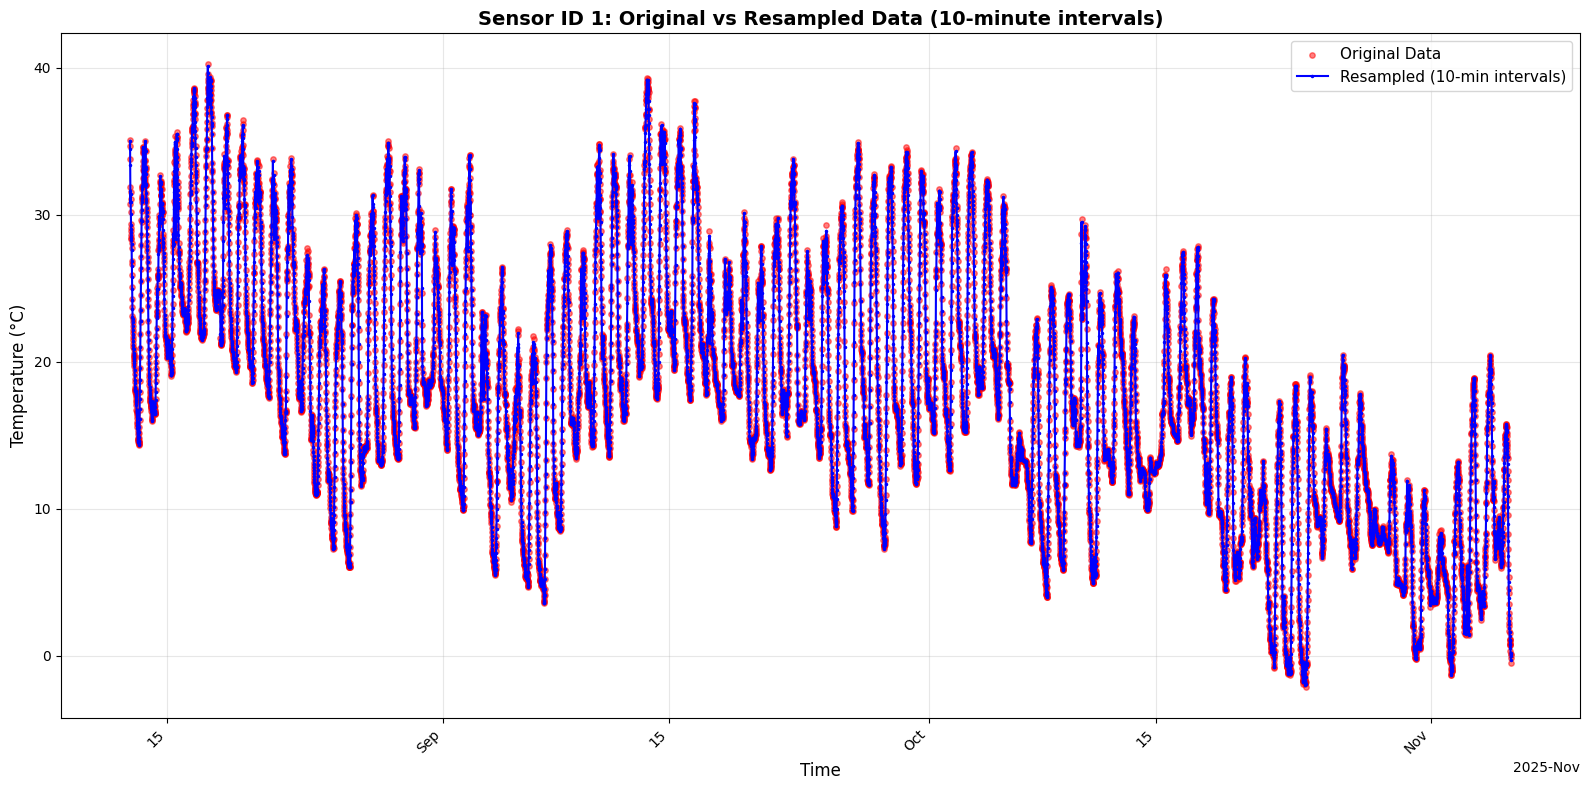

Original data points: 12252
Resampled data points: 12271

Original time range: 2025-08-12 17:07:56 to 2025-11-05 22:15:33
Resampled time range: 2025-08-12 17:10:00 to 2025-11-05 22:10:00


In [54]:
# Plot original and resampled data on the same plot
fig, ax = plt.subplots(figsize=(16, 8))

# Plot original data as scatter points
ax.scatter(sensor_1_data['datetime'], sensor_1_data['upper_temp_C'], 
          alpha=0.5, s=15, color='red', label='Original Data', marker='o')

# Plot resampled data as a line
ax.plot(sensor_1_final['datetime'], sensor_1_final['upper_temp_C'], 
       linewidth=1.5, color='blue', label='Resampled (10-min intervals)', linestyle='-', marker='.', markersize=3)

ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title('Sensor ID 1: Original vs Resampled Data (10-minute intervals)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Format x-axis dates
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

print(f"Original data points: {len(sensor_1_data)}")
print(f"Resampled data points: {len(sensor_1_final)}")
print(f"\nOriginal time range: {sensor_1_data['datetime'].min()} to {sensor_1_data['datetime'].max()}")
print(f"Resampled time range: {sensor_1_final['datetime'].min()} to {sensor_1_final['datetime'].max()}")


In [55]:
# Save the resampled data to a new Excel file
output_file = 'data/sensor_1_resampled.xlsx'
sensor_1_final.to_excel(output_file, index=False)

print(f"Resampled data saved to: {output_file}")
print(f"File contains {len(sensor_1_final)} rows with columns: {sensor_1_final.columns.tolist()}")


PermissionError: [Errno 13] Permission denied: 'data/sensor_1_resampled.xlsx'

In [56]:
# Read and process eu_1 power data from august_fivemin_power.csv
import pandas as pd

# Read the power data file
power_file = '../aug_2025/Area_1/august_fivemin_power.csv'
df_power = pd.read_csv(power_file)

print(f"Original data shape: {df_power.shape}")
print(f"Columns: {df_power.columns.tolist()[:5]}...")  # Show first few columns

# Parse the time column to datetime
df_power['datetime'] = pd.to_datetime(df_power['time (min)'], format='%m/%d/%Y %H:%M')

# Select only datetime and eu_1 columns
eu_1_data = df_power[['datetime', 'eu_1 (W)']].copy()
eu_1_data = eu_1_data.rename(columns={'eu_1 (W)': 'power_W'})

# Filter from 2025/08/12 17:00 to the end
start_time = pd.Timestamp('2025-08-12 17:00:00')
eu_1_filtered = eu_1_data[eu_1_data['datetime'] >= start_time].copy()
eu_1_filtered = eu_1_filtered.sort_values('datetime').reset_index(drop=True)

print(f"\nFiltered data (from {start_time} to end):")
print(f"Data shape: {eu_1_filtered.shape}")
print(f"Time range: {eu_1_filtered['datetime'].min()} to {eu_1_filtered['datetime'].max()}")
print(f"\nFirst few rows:")
print(eu_1_filtered.head(10))


Original data shape: (8928, 37)
Columns: ['time (min)', 'eu_1 (W)', 'eu_2 (W)', 'eu_3 (W)', 'eu_4 (W)']...

Filtered data (from 2025-08-12 17:00:00 to end):
Data shape: (5556, 2)
Time range: 2025-08-12 17:00:00 to 2025-08-31 23:55:00

First few rows:
             datetime    power_W
0 2025-08-12 17:00:00  6192.6783
1 2025-08-12 17:05:00  6262.1696
2 2025-08-12 17:10:00  6440.6052
3 2025-08-12 17:15:00  6332.7153
4 2025-08-12 17:20:00  5946.9990
5 2025-08-12 17:25:00  2307.4662
6 2025-08-12 17:30:00   903.9880
7 2025-08-12 17:35:00   716.9059
8 2025-08-12 17:40:00   930.7816
9 2025-08-12 17:45:00  2301.6008


In [57]:
# Filter to 10-minute intervals (no interpolation needed - timestamps already match)
# Remove duplicates first
eu_1_filtered = eu_1_filtered.drop_duplicates(subset=['datetime'], keep='first')

# Create 10-minute grid starting from 2025-08-12 17:00:00
end_time = eu_1_filtered['datetime'].max()
resample_range = pd.date_range(
    start=start_time,
    end=end_time,
    freq='10min'
)

print(f"10-minute grid:")
print(f"  Start: {start_time}")
print(f"  End: {end_time}")
print(f"  Number of grid points: {len(resample_range)}")

# Filter data to only include timestamps that match the 10-minute grid
eu_1_final = eu_1_filtered[eu_1_filtered['datetime'].isin(resample_range)].copy()
eu_1_final = eu_1_final.sort_values('datetime').reset_index(drop=True)

print(f"\nFiltered data (10-minute intervals):")
print(f"Data shape: {eu_1_final.shape}")
print(f"Time range: {eu_1_final['datetime'].min()} to {eu_1_final['datetime'].max()}")
print(f"\nPower data for eu_1 from 2025/08/12 17:00 to end (every 10 min):")
print(eu_1_final.to_string(index=False))


10-minute grid:
  Start: 2025-08-12 17:00:00
  End: 2025-08-31 23:55:00
  Number of grid points: 2778

Filtered data (10-minute intervals):
Data shape: (2778, 2)
Time range: 2025-08-12 17:00:00 to 2025-08-31 23:50:00

Power data for eu_1 from 2025/08/12 17:00 to end (every 10 min):
           datetime     power_W
2025-08-12 17:00:00 6192.678300
2025-08-12 17:10:00 6440.605200
2025-08-12 17:20:00 5946.999000
2025-08-12 17:30:00  903.988000
2025-08-12 17:40:00  930.781600
2025-08-12 17:50:00 4253.233600
2025-08-12 18:00:00 6176.205400
2025-08-12 18:10:00 5509.655100
2025-08-12 18:20:00 5081.652600
2025-08-12 18:30:00 4515.904600
2025-08-12 18:40:00 3892.320000
2025-08-12 18:50:00 3275.351100
2025-08-12 19:00:00 2728.359200
2025-08-12 19:10:00 2149.757600
2025-08-12 19:20:00 1591.050500
2025-08-12 19:30:00  924.938300
2025-08-12 19:40:00  576.855000
2025-08-12 19:50:00  250.020000
2025-08-12 20:00:00   37.264200
2025-08-12 20:10:00    0.000000
2025-08-12 20:20:00    0.000000
2025-08-12 20

In [58]:
# Read and process eu_1 power data from september_fivemin_power.csv
power_file_sep = '../sep_2025/Area_1/september_fivemin_power.csv'
df_power_sep = pd.read_csv(power_file_sep)

print(f"September - Original data shape: {df_power_sep.shape}")

# Parse the time column to datetime (pandas will auto-detect format)
df_power_sep['datetime'] = pd.to_datetime(df_power_sep['time (min)'])

# Select only datetime and eu_1 columns
eu_1_data_sep = df_power_sep[['datetime', 'eu_1 (W)']].copy()
eu_1_data_sep = eu_1_data_sep.rename(columns={'eu_1 (W)': 'power_W'})

# Filter from 2025/08/12 17:00 to the end
start_time = pd.Timestamp('2025-08-12 17:00:00')
eu_1_filtered_sep = eu_1_data_sep[eu_1_data_sep['datetime'] >= start_time].copy()
eu_1_filtered_sep = eu_1_filtered_sep.sort_values('datetime').reset_index(drop=True)

print(f"\nSeptember - Filtered data (from {start_time} to end):")
print(f"Data shape: {eu_1_filtered_sep.shape}")
print(f"Time range: {eu_1_filtered_sep['datetime'].min()} to {eu_1_filtered_sep['datetime'].max()}")

# Remove duplicates and filter to 10-minute intervals
eu_1_filtered_sep = eu_1_filtered_sep.drop_duplicates(subset=['datetime'], keep='first')
end_time_sep = eu_1_filtered_sep['datetime'].max()
resample_range_sep = pd.date_range(start=start_time, end=end_time_sep, freq='10min')

eu_1_final_sep = eu_1_filtered_sep[eu_1_filtered_sep['datetime'].isin(resample_range_sep)].copy()
eu_1_final_sep = eu_1_final_sep.sort_values('datetime').reset_index(drop=True)

print(f"\nSeptember - Filtered data (10-minute intervals):")
print(f"Data shape: {eu_1_final_sep.shape}")
print(f"Time range: {eu_1_final_sep['datetime'].min()} to {eu_1_final_sep['datetime'].max()}")
print(f"\nSeptember power data for eu_1 from 2025/08/12 17:00 to end (every 10 min):")
print(eu_1_final_sep.to_string(index=False))


September - Original data shape: (8640, 37)

September - Filtered data (from 2025-08-12 17:00:00 to end):
Data shape: (8640, 2)
Time range: 2025-09-01 00:00:00 to 2025-09-30 23:55:00

September - Filtered data (10-minute intervals):
Data shape: (4320, 2)
Time range: 2025-09-01 00:00:00 to 2025-09-30 23:50:00

September power data for eu_1 from 2025/08/12 17:00 to end (every 10 min):
           datetime     power_W
2025-09-01 00:00:00    0.000000
2025-09-01 00:10:00    0.000000
2025-09-01 00:20:00    0.000000
2025-09-01 00:30:00    0.000000
2025-09-01 00:40:00    0.000000
2025-09-01 00:50:00    0.000000
2025-09-01 01:00:00    0.000000
2025-09-01 01:10:00    0.000000
2025-09-01 01:20:00    0.000000
2025-09-01 01:30:00    0.000000
2025-09-01 01:40:00    0.000000
2025-09-01 01:50:00    0.000000
2025-09-01 02:00:00    0.000000
2025-09-01 02:10:00    0.000000
2025-09-01 02:20:00    0.000000
2025-09-01 02:30:00    0.000000
2025-09-01 02:40:00    0.000000
2025-09-01 02:50:00    0.000000
2025-0

In [59]:
# Read and process eu_1 power data from october_fivemin_power.csv
power_file_oct = '../oct_2025/Area_1/october_fivemin_power.csv'
df_power_oct = pd.read_csv(power_file_oct)

print(f"October - Original data shape: {df_power_oct.shape}")

# Parse the time column to datetime (October uses ISO8601 format)
df_power_oct['datetime'] = pd.to_datetime(df_power_oct['time (min)'])

# Select only datetime and eu_1 columns
eu_1_data_oct = df_power_oct[['datetime', 'eu_1 (W)']].copy()
eu_1_data_oct = eu_1_data_oct.rename(columns={'eu_1 (W)': 'power_W'})

# Filter from 2025/08/12 17:00 to the end
start_time = pd.Timestamp('2025-08-12 17:00:00')
eu_1_filtered_oct = eu_1_data_oct[eu_1_data_oct['datetime'] >= start_time].copy()
eu_1_filtered_oct = eu_1_filtered_oct.sort_values('datetime').reset_index(drop=True)

print(f"\nOctober - Filtered data (from {start_time} to end):")
print(f"Data shape: {eu_1_filtered_oct.shape}")
print(f"Time range: {eu_1_filtered_oct['datetime'].min()} to {eu_1_filtered_oct['datetime'].max()}")

# Remove duplicates and filter to 10-minute intervals
eu_1_filtered_oct = eu_1_filtered_oct.drop_duplicates(subset=['datetime'], keep='first')
end_time_oct = eu_1_filtered_oct['datetime'].max()
resample_range_oct = pd.date_range(start=start_time, end=end_time_oct, freq='10min')

eu_1_final_oct = eu_1_filtered_oct[eu_1_filtered_oct['datetime'].isin(resample_range_oct)].copy()
eu_1_final_oct = eu_1_final_oct.sort_values('datetime').reset_index(drop=True)

print(f"\nOctober - Filtered data (10-minute intervals):")
print(f"Data shape: {eu_1_final_oct.shape}")
print(f"Time range: {eu_1_final_oct['datetime'].min()} to {eu_1_final_oct['datetime'].max()}")
print(f"\nOctober power data for eu_1 from 2025/08/12 17:00 to end (every 10 min):")
print(eu_1_final_oct.to_string(index=False))


October - Original data shape: (8928, 37)

October - Filtered data (from 2025-08-12 17:00:00 to end):
Data shape: (8928, 2)
Time range: 2025-10-01 00:00:00 to 2025-10-31 23:55:00

October - Filtered data (10-minute intervals):
Data shape: (4464, 2)
Time range: 2025-10-01 00:00:00 to 2025-10-31 23:50:00

October power data for eu_1 from 2025/08/12 17:00 to end (every 10 min):
           datetime     power_W
2025-10-01 00:00:00    0.000000
2025-10-01 00:10:00    0.000000
2025-10-01 00:20:00    0.000000
2025-10-01 00:30:00    0.000000
2025-10-01 00:40:00    0.000000
2025-10-01 00:50:00    0.000000
2025-10-01 01:00:00    0.000000
2025-10-01 01:10:00    0.000000
2025-10-01 01:20:00    0.000000
2025-10-01 01:30:00    0.000000
2025-10-01 01:40:00    0.000000
2025-10-01 01:50:00    0.000000
2025-10-01 02:00:00    0.000000
2025-10-01 02:10:00    0.000000
2025-10-01 02:20:00    0.000000
2025-10-01 02:30:00    0.000000
2025-10-01 02:40:00    0.000000
2025-10-01 02:50:00    0.000000
2025-10-01 03:

In [60]:
# Combine all power data (August, September, October)
print("Combining power data from all months...")

# Combine all power dataframes
all_power_data = pd.concat([
    eu_1_final,
    eu_1_final_sep,
    eu_1_final_oct
], ignore_index=True)

# Sort by datetime
all_power_data = all_power_data.sort_values('datetime').reset_index(drop=True)

print(f"Combined power data shape: {all_power_data.shape}")
print(f"Time range: {all_power_data['datetime'].min()} to {all_power_data['datetime'].max()}")
print(f"\nFirst few rows of combined power data:")
print(all_power_data.head(10))


Combining power data from all months...
Combined power data shape: (11562, 2)
Time range: 2025-08-12 17:00:00 to 2025-10-31 23:50:00

First few rows of combined power data:
             datetime    power_W
0 2025-08-12 17:00:00  6192.6783
1 2025-08-12 17:10:00  6440.6052
2 2025-08-12 17:20:00  5946.9990
3 2025-08-12 17:30:00   903.9880
4 2025-08-12 17:40:00   930.7816
5 2025-08-12 17:50:00  4253.2336
6 2025-08-12 18:00:00  6176.2054
7 2025-08-12 18:10:00  5509.6551
8 2025-08-12 18:20:00  5081.6526
9 2025-08-12 18:30:00  4515.9046


In [61]:
# Merge temperature/humidity/irradiance data with power data
print("Merging sensor data with power data...")

# Ensure datetime columns are the same type
sensor_1_final['datetime'] = pd.to_datetime(sensor_1_final['datetime'])
all_power_data['datetime'] = pd.to_datetime(all_power_data['datetime'])

# Merge on datetime (inner join to keep only matching timestamps)
combined_data = pd.merge(
    sensor_1_final,
    all_power_data,
    on='datetime',
    how='inner'
)

# Sort by datetime
combined_data = combined_data.sort_values('datetime').reset_index(drop=True)

print(f"Combined dataset shape: {combined_data.shape}")
print(f"Columns: {combined_data.columns.tolist()}")
print(f"Time range: {combined_data['datetime'].min()} to {combined_data['datetime'].max()}")
print(f"\nFirst few rows of combined data:")
print(combined_data.head(10))
print(f"\nLast few rows of combined data:")
print(combined_data.tail(10))


Merging sensor data with power data...
Combined dataset shape: (11561, 5)
Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']
Time range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00

First few rows of combined data:
             datetime  upper_temp_C  upper_humidity  upper_irradiance  \
0 2025-08-12 17:10:00     35.029218       46.076972      17734.723861   
1 2025-08-12 17:20:00     34.493760       46.926855      15730.205846   
2 2025-08-12 17:30:00     33.384309       50.454709      10021.902652   
3 2025-08-12 17:40:00     31.642496       57.893710      10409.131008   
4 2025-08-12 17:50:00     30.897737       60.972579      12807.664386   
5 2025-08-12 18:00:00     31.440899       58.576123      12237.084190   
6 2025-08-12 18:10:00     30.903295       54.456988       9550.013700   
7 2025-08-12 18:20:00     30.020366       54.827920       8072.365046   
8 2025-08-12 18:30:00     29.309817       57.759900       7260.722753   
9 2025-08-12 18:40:0

In [62]:
# Save the combined data to Excel file
output_file = 'data/sensor_1_combined_data.xlsx'
combined_data.to_excel(output_file, index=False)

print(f"Combined data saved to: {output_file}")
print(f"\nFile contains:")
print(f"  - {len(combined_data)} rows")
print(f"  - Columns: {combined_data.columns.tolist()}")
print(f"  - Time range: {combined_data['datetime'].min()} to {combined_data['datetime'].max()}")
print(f"\nSummary statistics:")
print(combined_data[['upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']].describe())


Combined data saved to: data/sensor_1_combined_data.xlsx

File contains:
  - 11561 rows
  - Columns: ['datetime', 'upper_temp_C', 'upper_humidity', 'upper_irradiance', 'power_W']
  - Time range: 2025-08-12 17:10:00 to 2025-10-31 23:50:00

Summary statistics:
       upper_temp_C  upper_humidity  upper_irradiance       power_W
count  11561.000000    11561.000000      11561.000000  11561.000000
mean      18.553006       71.515402       6363.312085   1773.975319
std        8.206737       20.474228       8201.877632   2471.983440
min       -1.980982       22.505524          0.000000      0.000000
25%       12.919884       53.796489          0.000000      0.000000
50%       18.027072       74.936539        297.306798      0.000000
75%       24.288136       90.459634      13509.022980   3652.183400
max       40.122379       99.929201      30531.765411   8739.079800
